# ME5413 Homework 3: Planning

## Task 0: Load the Map

In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import heapq
import itertools
import time
import cv2
import random
import functools

%matplotlib inline

/tmp/ipykernel_37911/187924686.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  floor_plan = imageio.imread('./map/vivocity.png')
/tmp/ipykernel_37911/187924686.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  grid_map_img = imageio.imread('./map/vivocity_freespace.png')


Size of the map: (1000, 1000)
Occupied Cells: 823039
Free Cells: 176961


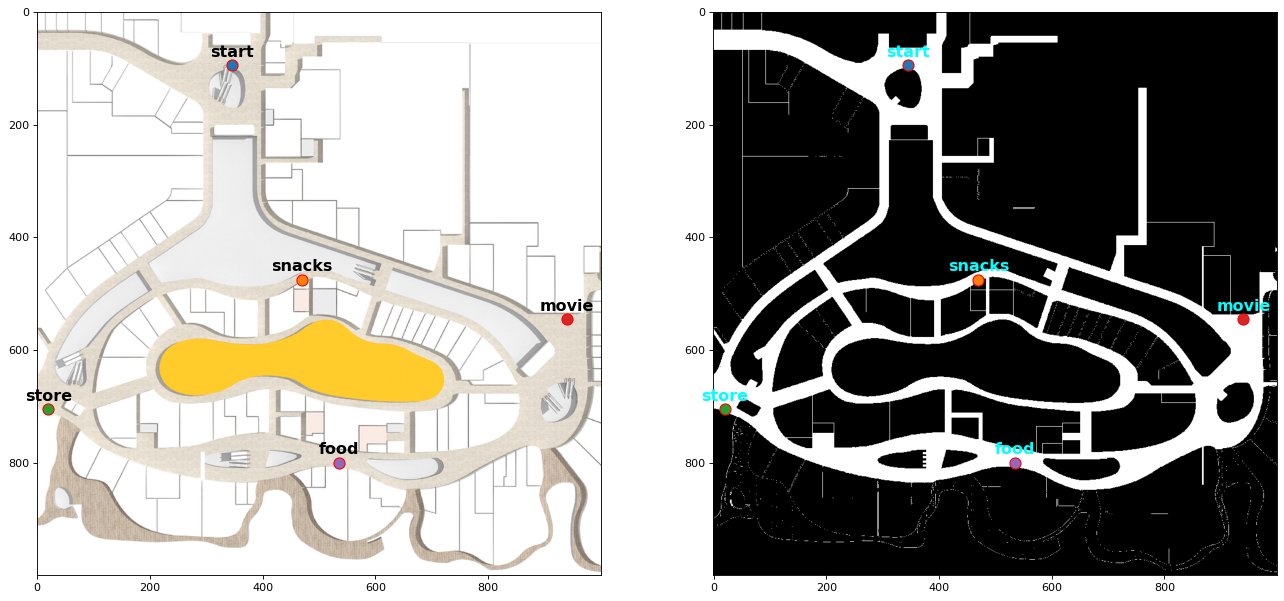

Cell start is free: True
Cell snacks is free: True
Cell store is free: True
Cell movie is free: True
Cell food is free: True


In [2]:
# Load the map
floor_plan = imageio.imread('./map/vivocity.png')
grid_map_img = imageio.imread('./map/vivocity_freespace.png')
grid_map = grid_map_img.transpose()
print("Size of the map:", grid_map.shape)
print("Occupied Cells:", np.count_nonzero(grid_map == 0))
print("Free Cells:", np.count_nonzero(grid_map == 255))

# Map resolution (Constant)
MAP_RES = 0.2 # each cell represents a 0.2m x 0.2m square in reality

# Locations on the map
locations = {'start':  [345, 95],    # Start from the level 2 Escalator
             'snacks': [470, 475],   # Garrett Popcorn
             'store':  [20, 705],    # DJI Store
             'movie':  [940, 545],   # Golden Village
             'food':   [535, 800],   # PUTIEN
            }

# A helper function to mark the locations on the map
def plot_locations(locations: dict, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')
    return

# Plot the locaitons on the map 
plt.figure(figsize=(20, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(floor_plan)
plot_locations(locations)
plt.subplot(1,2,2)
plt.imshow(grid_map_img, cmap='gray')
plot_locations(locations, color='cyan')
plt.show()

# Check if the designated locations are free
for key, value in locations.items():
    print(f"Cell {key} is free: {grid_map[value[0], value[1]] == 255}")

## Task 1
### Task 1.1 Heuristic Function - Euclidean Distance

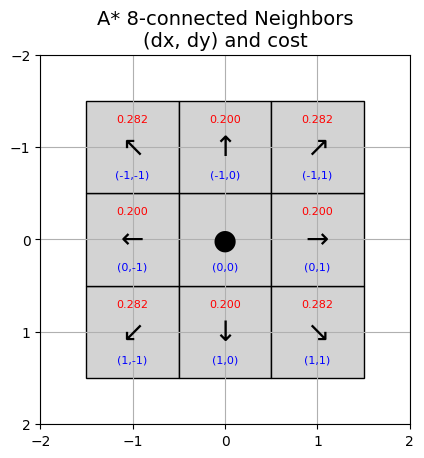

Cell start is free: True
Cell snacks is free: True
Cell store is free: True
Cell movie is free: True
Cell food is free: True

Distance table (unit: meters)
From\To	start	snacks	store	movie	food
start	0.0	143.28	155.26	178.91	224.70
snacks	143.28	0.0	115.21	108.11	134.31
store	155.26	115.21	0.0	210.02	111.12
movie	178.91	108.11	210.02	0.0	113.71
food	224.70	134.31	111.12	113.71	0.0


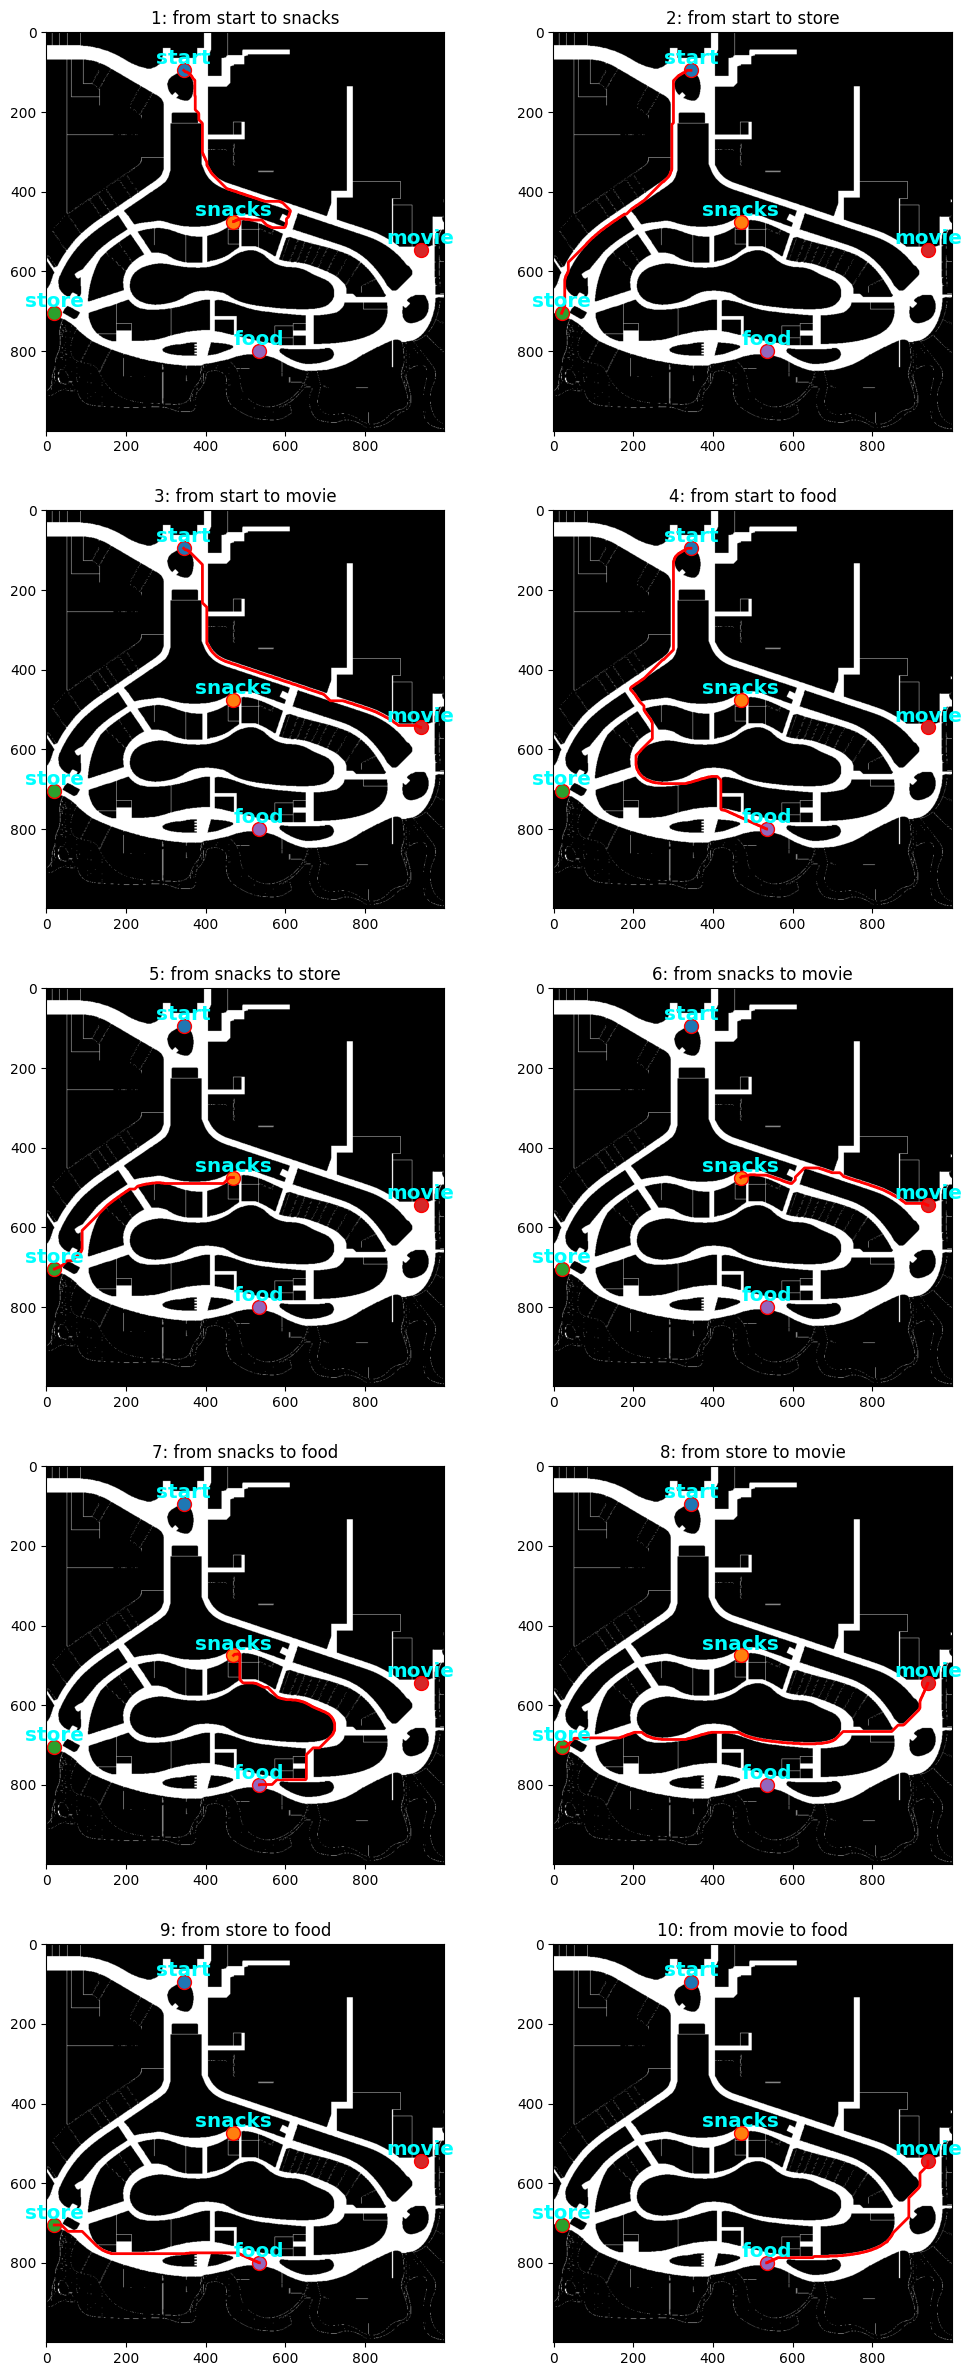

In [3]:
# Expansion barrier with 0.3m radius
HUMAN_RADIUS = 0.3
dilation_radius = int(np.ceil(HUMAN_RADIUS / MAP_RES))  # unit: pixel
kernel_size = dilation_radius * 2 + 1
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))

plt.imshow(kernel, cmap="gray")
plt.title("Kernel Structuring (Approx. Circle)")
plt.axis("off")
plt.show()

# Defining neighbor directions and cost (dx, dy, arrow, cost)
neighbors = [
    (1, -1, "↙", 0.282),
    (1, 0, "↓", 0.2),
    (1, 1, "↘", 0.282),
    (0, -1, "←", 0.2),
    (0, 0, "●", 0.0),
    (0, 1, "→", 0.2),
    (-1, -1, "↖", 0.282),
    (-1, 0, "↑", 0.2),
    (-1, 1, "↗", 0.282),
]

fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_xticks(range(-2, 3))
ax.set_yticks(range(-2, 3))
plt.gca().invert_yaxis()
ax.grid(True)

for dx, dy, arrow, cost in neighbors:
    x = dy
    y = dx

    rect = patches.Rectangle(
        (x - 0.5, y - 0.5), 1, 1, linewidth=1, edgecolor="black", facecolor="lightgray"
    )
    ax.add_patch(rect)
    ax.text(x, y, arrow, ha="center", va="center", fontsize=20, color="black")
    ax.text(
        x, y + 0.3, f"({dx},{dy})", ha="center", va="center", fontsize=8, color="blue"
    )
    if cost > 0:
        ax.text(
            x, y - 0.3, f"{cost:.3f}", ha="center", va="center", fontsize=8, color="red"
        )

ax.set_title("A* 8-connected Neighbors\n(dx, dy) and cost", fontsize=14)
plt.show()

# Expand obstacle area: Make the obstacle (0) "fatter" and occupy the surrounding free area
obstacle_mask = (grid_map == 0).astype(np.uint8)
obstacle_dilated = cv2.dilate(obstacle_mask, kernel, iterations=1)

# Build the inflated map (0=obstructed, 255=free)
grid_map_dilated = np.ones_like(grid_map) * 255  # white
grid_map_dilated[obstacle_dilated == 1] = 0  # black

# Visualization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Map")
plt.imshow(grid_map.T, cmap="gray")
plot_locations(locations, color="cyan")

plt.subplot(1, 2, 2)
plt.title(f"Map after expansion (considering 0.3m radius)")
plt.imshow(grid_map_dilated.T, cmap="gray")
plot_locations(locations, color="cyan")
plt.show()

# Check if the designated locations are free
for key, value in locations.items():
    print(f"Cell {key} is free: {grid_map_dilated[value[0], value[1]] == 255}")


# Path Planning: A* with Euclidean Distance
def astar(start, goal, grid_map, map_res):
    h, w = grid_map.shape
    # Open list, implemented with a minimum heap (priority queue)
    frontier = []
    heapq.heappush(frontier, (0, tuple(start)))
    # Record which point each point came from (for backtracking)
    came_from = {}
    # Record the actual cost g value from the starting point to the current point
    cost_so_far = {tuple(start): 0}

    # 8-connected neighbors and cost values
    neighbors = [
        (-1, 0, 0.2),  # up
        (1, 0, 0.2),  # down
        (0, -1, 0.2),  # left
        (0, 1, 0.2),  # right
        (-1, -1, 0.282),  # top left
        (-1, 1, 0.282),  # top right
        (1, -1, 0.282),  # bottom left
        (1, 1, 0.282),  # bottom right
    ]

    # Heuristic function: Euclidean distance
    def heuristic(a, b):
        dx = abs(a[0] - b[0]) * map_res
        dy = abs(a[1] - b[1]) * map_res
        return np.hypot(dx, dy)

    visited_cells = set()
    start_time = time.time()

    # Minimize f = g + h
    while frontier:
        _, current = heapq.heappop(frontier)
        visited_cells.add(current)

        if current == tuple(goal):
            # Backtracking Path
            path = [current]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            path.reverse()
            total_dist = cost_so_far[tuple(goal)]
            runtime = time.time() - start_time
            return path, total_dist, visited_cells, runtime

        # Try each direction of the current node
        for dx, dy, cost in neighbors:
            # Calculate a new position
            nx, ny = current[0] + dx, current[1] + dy
            # Determine whether the point is within the map and is not an obstacle
            if 0 <= nx < h and 0 <= ny < w and grid_map[nx, ny] == 255:
                neighbor = (nx, ny)
                tentative_g = cost_so_far[current] + cost
                if neighbor not in cost_so_far or tentative_g < cost_so_far[neighbor]:
                    cost_so_far[neighbor] = tentative_g
                    f_score = tentative_g + heuristic(neighbor, goal)
                    heapq.heappush(frontier, (f_score, neighbor))
                    came_from[neighbor] = current

    return None, float("inf"), visited_cells, time.time() - start_time  # Unreachable


# Compute the shortest path between all pairs of designated locations
astar_ed_distance_table = {}
astar_ed_path_table = {}
astar_ed_runtime_table = {}
astar_ed_visited_count_table = {}

keys = list(locations.keys())

for from_key, to_key in itertools.combinations(keys, 2):
    start_pt = locations[from_key]
    goal_pt = locations[to_key]
    path, dist, visited_cells, runtime = astar(
        start_pt, goal_pt, grid_map_dilated, MAP_RES
    )

    # Storage path, distance, number of visited cells, and running time
    astar_ed_distance_table[(from_key, to_key)] = dist
    astar_ed_distance_table[(to_key, from_key)] = dist
    astar_ed_path_table[(from_key, to_key)] = path
    astar_ed_path_table[(to_key, from_key)] = path[::-1]
    astar_ed_visited_count_table[(from_key, to_key)] = len(visited_cells)
    astar_ed_visited_count_table[(to_key, from_key)] = len(visited_cells)
    astar_ed_runtime_table[(from_key, to_key)] = runtime
    astar_ed_runtime_table[(to_key, from_key)] = runtime

# Print distance table
print("\nDistance table (unit: meters)")
print("From\\To\t" + "\t".join(keys))
for from_key in keys:
    row = [from_key]
    for to_key in keys:
        if from_key == to_key:
            row.append("0.0")
        else:
            row.append(f"{astar_ed_distance_table[(from_key, to_key)]:.2f}")
    print("\t".join(row))

# Visualize the optimal path for each cell
plt.figure(figsize=(12, 30))
plt_num = 1
for from_key, to_key in itertools.combinations(keys, 2):
    plt.subplot(5, 2, plt_num)
    plt.imshow(grid_map_img, cmap="gray")
    plot_locations(locations, color="cyan")
    plt.title(f"{plt_num}: from {from_key} to {to_key}")
    # Draw paths
    path = astar_ed_path_table[(from_key, to_key)]
    x = [p[0] for p in path]
    y = [p[1] for p in path]
    plt.plot(x, y, c="red", linewidth=2)
    plt_num = plt_num + 1


### Task 1.2 Different Heuristic Function - Manhattan Distance


Distance table (unit: meters)
From\To	start	snacks	store	movie	food
start	0.0	143.28	155.26	178.91	224.81
snacks	143.28	0.0	119.26	108.11	134.31
store	155.26	119.26	0.0	210.02	111.12
movie	178.91	108.11	210.02	0.0	114.30
food	224.81	134.31	111.12	114.30	0.0


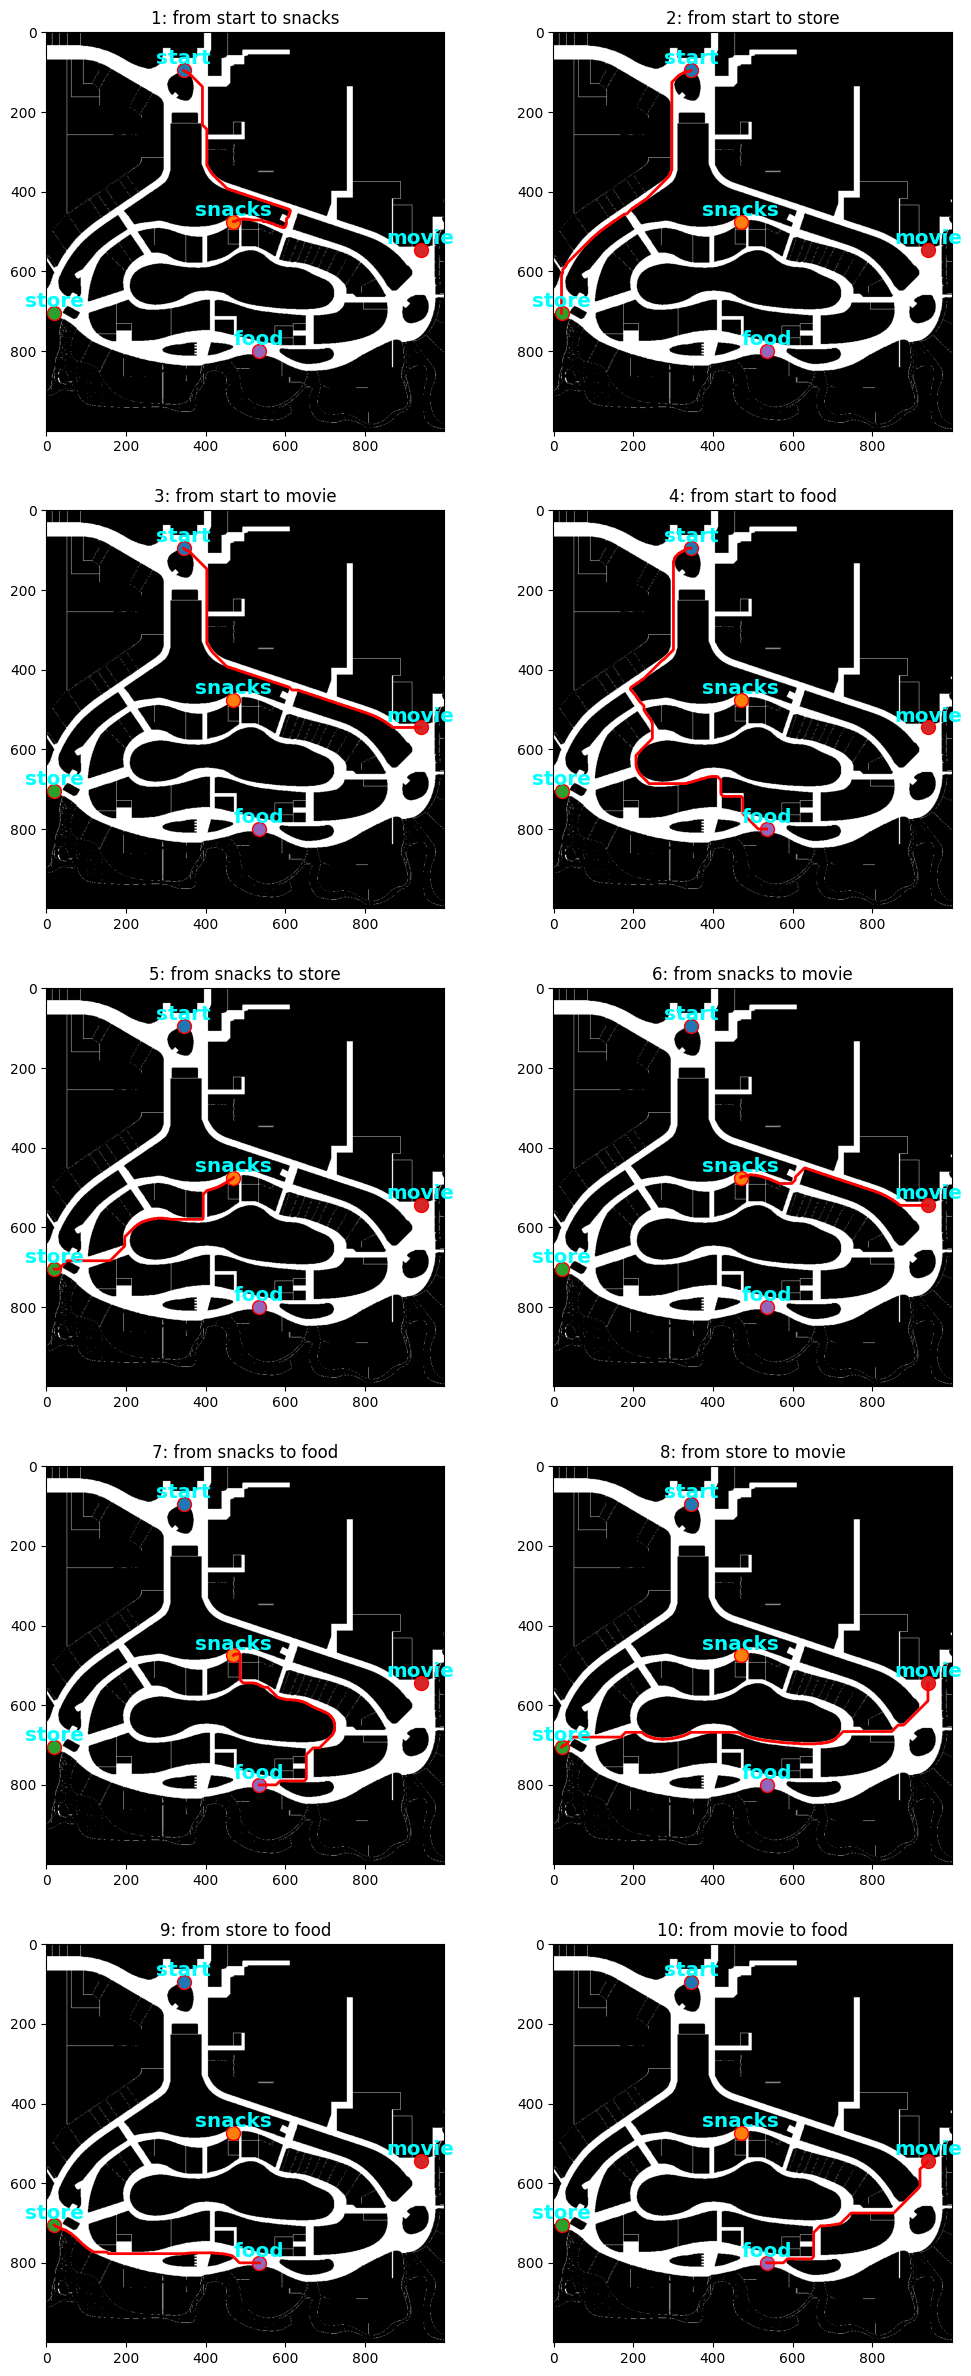

In [4]:
# Path Planning: A* with Manhattan Distance
def astar(start, goal, grid_map, map_res):
    h, w = grid_map.shape
    # Open list, implemented with a minimum heap (priority queue)
    frontier = []
    heapq.heappush(frontier, (0, tuple(start)))
    # Record which point each point came from (for backtracking)
    came_from = {}
    # Record the actual cost g value from the starting point to the current point
    cost_so_far = {tuple(start): 0}

    # 8-connected neighbors and cost values
    neighbors = [
        (-1, 0, 0.2),  # up
        (1, 0, 0.2),  # down
        (0, -1, 0.2),  # left
        (0, 1, 0.2),  # right
        (-1, -1, 0.282),  # top left
        (-1, 1, 0.282),  # top right
        (1, -1, 0.282),  # bottom left
        (1, 1, 0.282),  # bottom right
    ]

    # Heuristic function：Manhattan distance
    def heuristic(a, b):
        dx = abs(a[0] - b[0]) * map_res
        dy = abs(a[1] - b[1]) * map_res
        return dx + dy

    visited_cells = set()
    start_time = time.time()

    # Minimize f = g + h
    while frontier:
        _, current = heapq.heappop(frontier)
        visited_cells.add(current)

        if current == tuple(goal):
            # Backtracking Path
            path = [current]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            path.reverse()
            total_dist = cost_so_far[tuple(goal)]
            runtime = time.time() - start_time
            return path, total_dist, visited_cells, runtime

        # Try each direction of the current node
        for dx, dy, cost in neighbors:
            # Calculate a new position
            nx, ny = current[0] + dx, current[1] + dy
            # Determine whether the point is within the map and is not an obstacle
            if 0 <= nx < h and 0 <= ny < w and grid_map[nx, ny] == 255:
                neighbor = (nx, ny)
                tentative_g = cost_so_far[current] + cost
                if neighbor not in cost_so_far or tentative_g < cost_so_far[neighbor]:
                    cost_so_far[neighbor] = tentative_g
                    f_score = tentative_g + heuristic(neighbor, goal)
                    heapq.heappush(frontier, (f_score, neighbor))
                    came_from[neighbor] = current

    return None, float("inf"), visited_cells, time.time() - start_time  # Unreachable


# Compute the shortest path between all pairs of designated locations
astar_md_distance_table = {}
astar_md_path_table = {}
astar_md_runtime_table = {}
astar_md_visited_count_table = {}

keys = list(locations.keys())

for from_key, to_key in itertools.combinations(keys, 2):
    start_pt = locations[from_key]
    goal_pt = locations[to_key]
    path, dist, visited_cells, runtime = astar(
        start_pt, goal_pt, grid_map_dilated, MAP_RES
    )

    # Storage path, distance, number of visited cells, and running time
    astar_md_distance_table[(from_key, to_key)] = dist
    astar_md_distance_table[(to_key, from_key)] = dist
    astar_md_path_table[(from_key, to_key)] = path
    astar_md_path_table[(to_key, from_key)] = path[::-1]
    astar_md_visited_count_table[(from_key, to_key)] = len(visited_cells)
    astar_md_visited_count_table[(to_key, from_key)] = len(visited_cells)
    astar_md_runtime_table[(from_key, to_key)] = runtime
    astar_md_runtime_table[(to_key, from_key)] = runtime

# Print distance table
print("\nDistance table (unit: meters)")
print("From\\To\t" + "\t".join(keys))
for from_key in keys:
    row = [from_key]
    for to_key in keys:
        if from_key == to_key:
            row.append("0.0")
        else:
            row.append(f"{astar_md_distance_table[(from_key, to_key)]:.2f}")
    print("\t".join(row))

# Visualize the optimal path for each cell
plt.figure(figsize=(12, 30))
plt_num = 1
for from_key, to_key in itertools.combinations(keys, 2):
    plt.subplot(5, 2, plt_num)
    plt.imshow(grid_map_img, cmap="gray")
    plot_locations(locations, color="cyan")
    plt.title(f"{plt_num}: from {from_key} to {to_key}")
    # Draw paths
    path = astar_md_path_table[(from_key, to_key)]
    x = [p[0] for p in path]
    y = [p[1] for p in path]
    plt.plot(x, y, c="red", linewidth=2)
    plt_num = plt_num + 1


### Task 1.3 Greedy Best First Search Algorithm （GBFS）


Distance table (unit: meters) - Greedy Best First Search
From\To	start	snacks	store	movie	food
start	0.0	146.29	165.60	182.48	240.13
snacks	146.29	0.0	124.00	144.19	171.65
store	165.60	124.00	0.0	257.13	119.03
movie	182.48	144.19	257.13	0.0	208.22
food	240.13	171.65	119.03	208.22	0.0


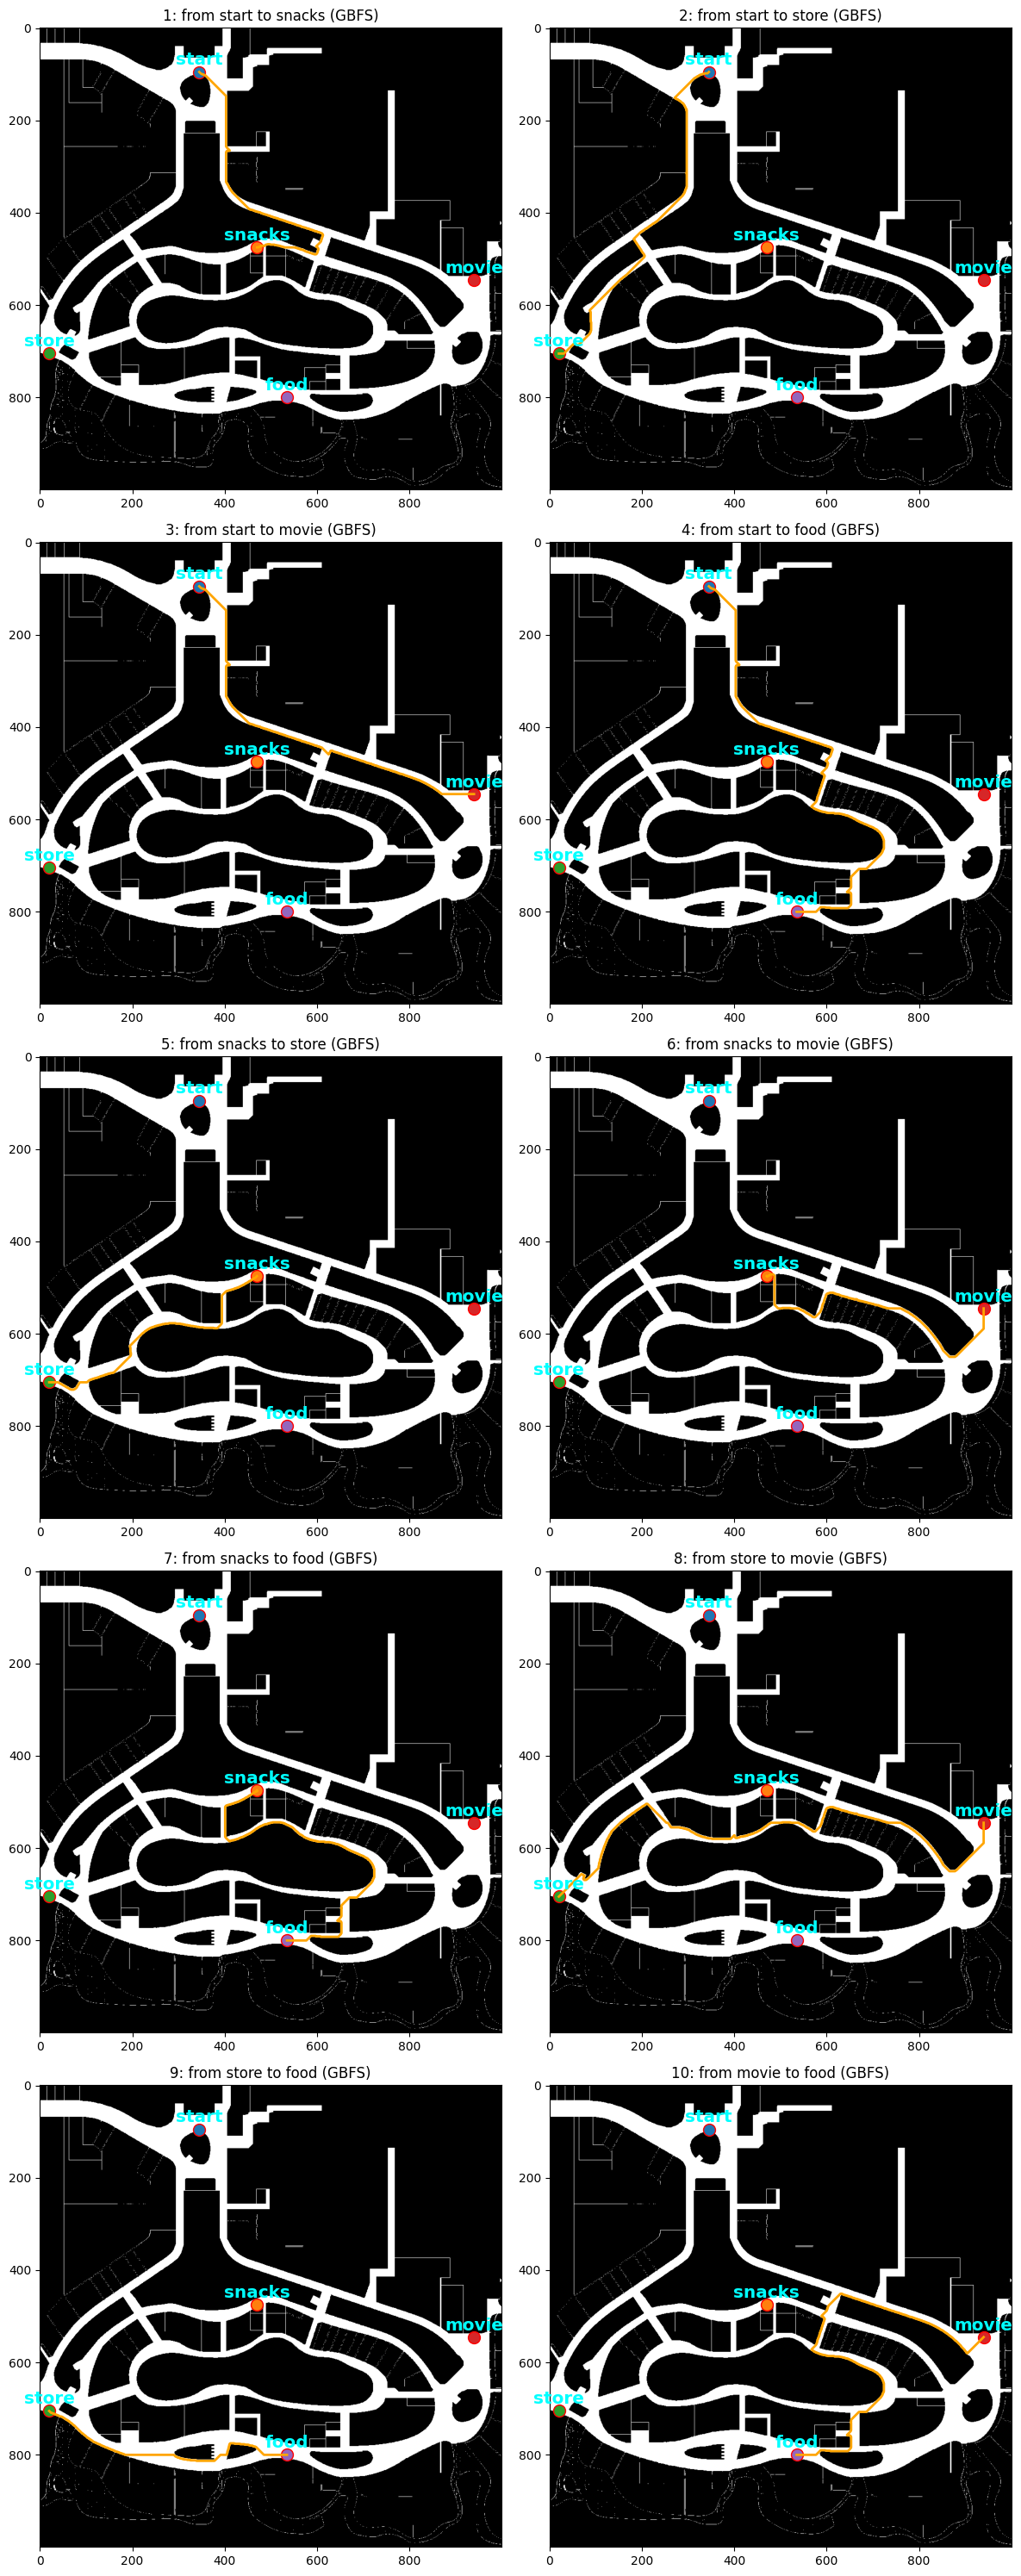

In [5]:
# Path Planning: Greedy Best First Search Algorithm
def gbfs(start, goal, grid_map, map_res):
    h, w = grid_map.shape
    start_time = time.time()

    class Node:
        def __init__(self, pos, cost=0.0, parent=None):
            self.pos = pos
            self.cost = cost
            self.parent = parent

        def __lt__(self, other):
            return self.cost < other.cost

    # Heuristic function: Euclidean distance
    def heuristic(p1, p2):
        dx = abs(p1[0] - p2[0]) * map_res
        dy = abs(p1[1] - p2[1]) * map_res
        return np.hypot(dx, dy)

    # 8-connected neighbors
    neighbor_offsets = [
        (-1, 0),
        (1, 0),
        (0, -1),
        (0, 1),
        (-1, -1),
        (-1, 1),
        (1, -1),
        (1, 1),
    ]

    start_node = Node(tuple(start))
    goal_node = Node(tuple(goal))
    frontier = []
    heapq.heappush(frontier, (heuristic(start, goal), start_node))

    visited_cells = set()

    while frontier:
        _, current = heapq.heappop(frontier)
        visited_cells.add(current.pos)

        if current.pos == goal_node.pos:
            # reconstruct path
            path = []
            while current:
                path.append(current.pos)
                current = current.parent
            path.reverse()

            # Accurate distance calculation (real world)
            total_dist = 0.0
            for i in range(1, len(path)):
                dx = abs(path[i][0] - path[i - 1][0])
                dy = abs(path[i][1] - path[i - 1][1])
                if dx + dy == 2:
                    total_dist += 0.282
                else:
                    total_dist += 0.2

            runtime = time.time() - start_time
            return path, total_dist, visited_cells, runtime

        for dx, dy in neighbor_offsets:
            nx, ny = current.pos[0] + dx, current.pos[1] + dy
            neighbor_pos = (nx, ny)

            if not (0 <= nx < h and 0 <= ny < w):
                continue
            if grid_map[nx, ny] != 255:
                continue
            if neighbor_pos in visited_cells:
                continue

            neighbor_node = Node(neighbor_pos, cost=0, parent=current)
            visited_cells.add(neighbor_pos)
            heapq.heappush(frontier, (heuristic(neighbor_pos, goal), neighbor_node))

    # If no path is found
    return None, float("inf"), visited_cells, time.time() - start_time


# Compute GBFS shortest paths between all location pairs
gbfs_distance_table = {}
gbfs_path_table = {}
gbfs_runtime_table = {}
gbfs_visited_count_table = {}

keys = list(locations.keys())

for from_key, to_key in itertools.combinations(keys, 2):
    start_pt = locations[from_key]
    goal_pt = locations[to_key]
    path, dist, visited_cells, runtime = gbfs(
        start_pt, goal_pt, grid_map_dilated, MAP_RES
    )

    gbfs_distance_table[(from_key, to_key)] = dist
    gbfs_distance_table[(to_key, from_key)] = dist
    gbfs_path_table[(from_key, to_key)] = path
    gbfs_path_table[(to_key, from_key)] = path[::-1] if path else None
    gbfs_visited_count_table[(from_key, to_key)] = len(visited_cells)
    gbfs_visited_count_table[(to_key, from_key)] = len(visited_cells)
    gbfs_runtime_table[(from_key, to_key)] = runtime
    gbfs_runtime_table[(to_key, from_key)] = runtime

# Print distance table
print("\nDistance table (unit: meters) - Greedy Best First Search")
print("From\\To\t" + "\t".join(keys))
for from_key in keys:
    row = [from_key]
    for to_key in keys:
        if from_key == to_key:
            row.append("0.0")
        else:
            row.append(f"{gbfs_distance_table[(from_key, to_key)]:.2f}")
    print("\t".join(row))

# Visualize the optimal GBFS path for each cell
plt.figure(figsize=(12, 30))
plt_num = 1
for from_key, to_key in itertools.combinations(keys, 2):
    plt.subplot(5, 2, plt_num)
    plt.imshow(grid_map_img, cmap="gray")
    plot_locations(locations, color="cyan")
    plt.title(f"{plt_num}: from {from_key} to {to_key} (GBFS)")
    path = gbfs_path_table[(from_key, to_key)]
    if path:
        x = [p[0] for p in path]
        y = [p[1] for p in path]
        plt.plot(x, y, c="orange", linewidth=2)
    else:
        plt.text(10, 10, "Unreachable", color="red", fontsize=12)
    plt_num += 1

plt.tight_layout()
plt.show()


### Task 1.4 Rapidly-exploring Random Tree (RRT)


Distance table (unit: meters) - RRT
From\To	start	snacks	store	movie	food
start	0.0	inf	inf	191.99	288.52
snacks	inf	0.0	127.91	inf	inf
store	inf	127.91	0.0	231.86	142.71
movie	191.99	inf	231.86	0.0	125.42
food	288.52	inf	142.71	125.42	0.0


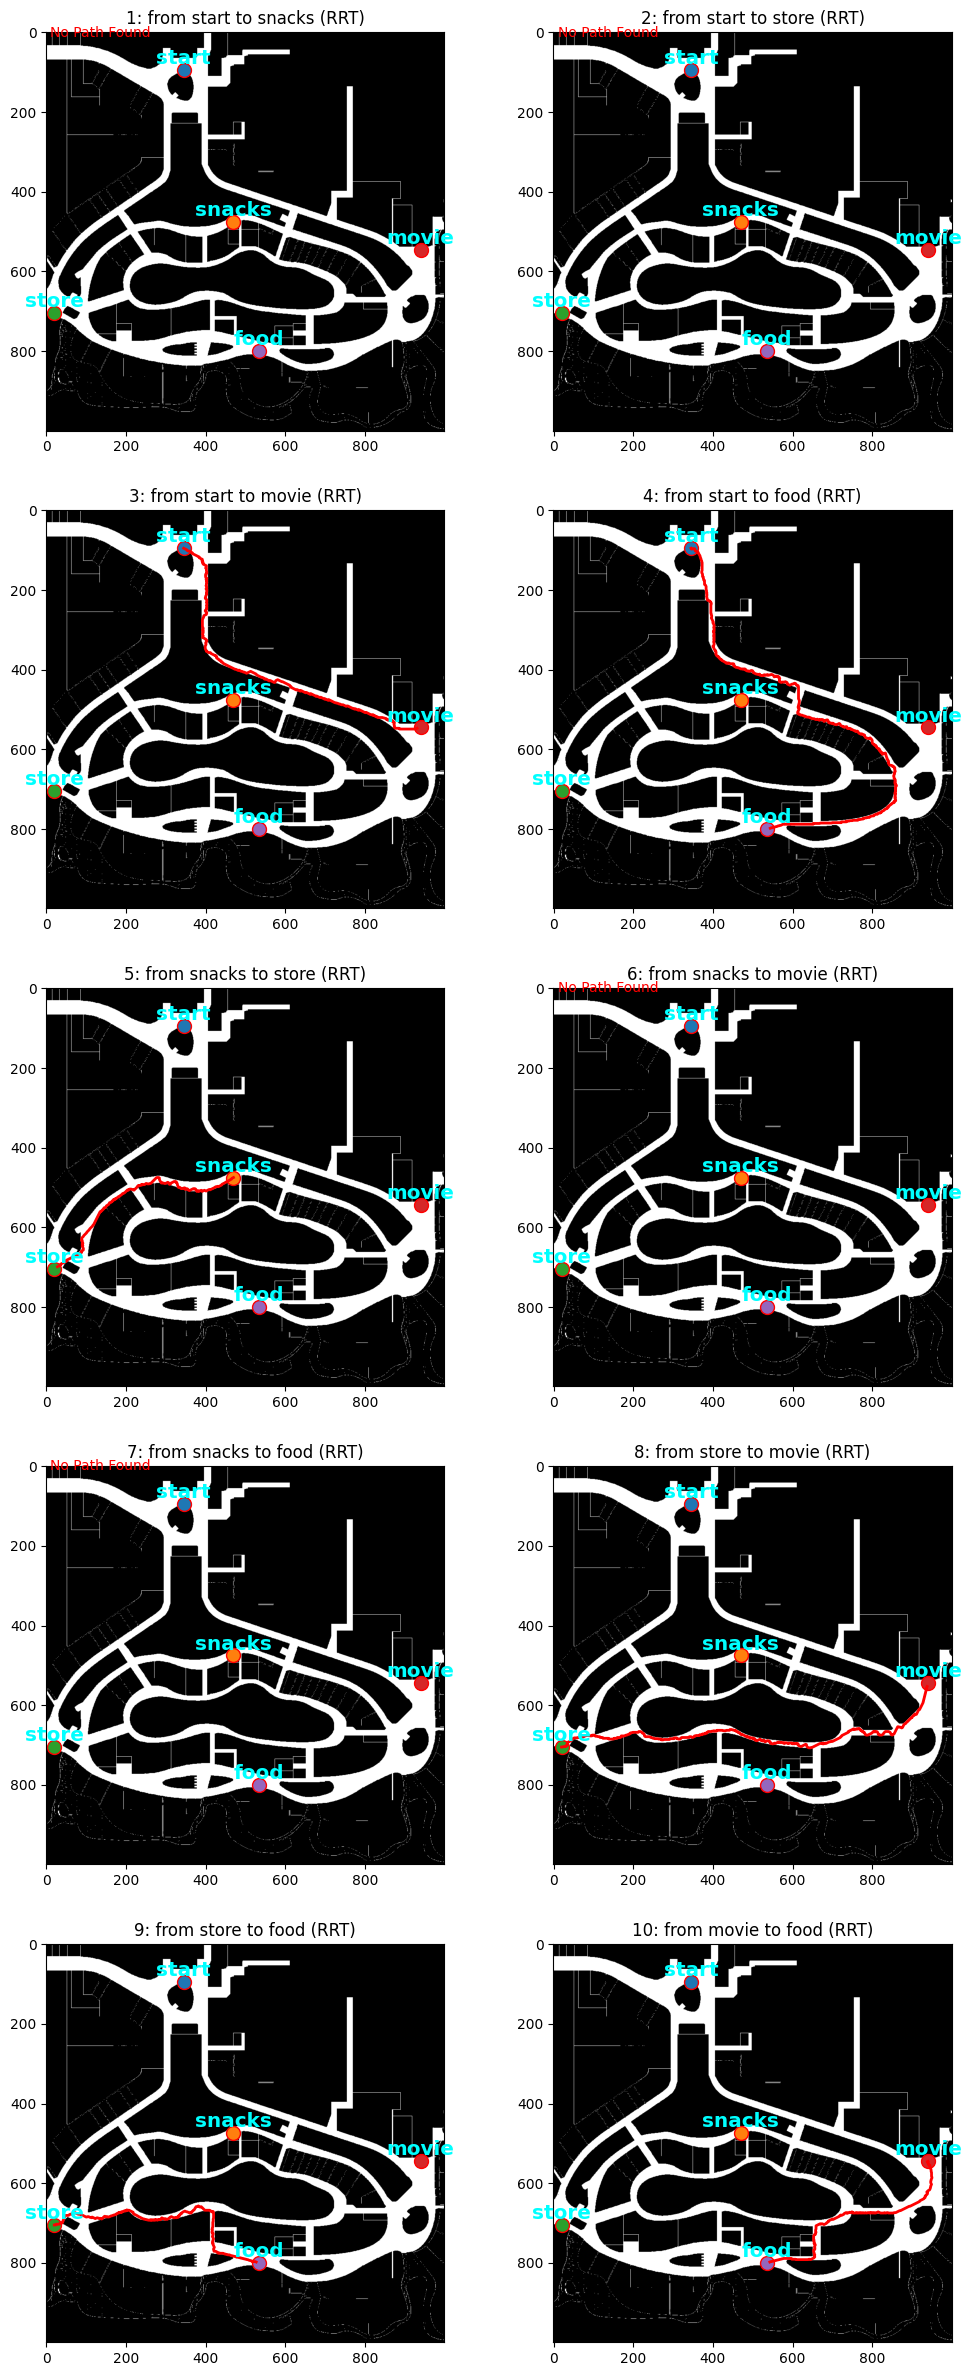

In [6]:
class Node:
    def __init__(self, pos, parent=None):
        self.pos = pos  # (x, y)
        self.parent = parent


def is_collision_free(p, grid_map):
    x, y = p
    h, w = grid_map.shape
    return 0 <= x < h and 0 <= y < w and grid_map[x, y] == 255


def get_distance(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))


def steer(from_node, to_pos, max_step=2):
    direction = np.array(to_pos) - np.array(from_node.pos)
    length = np.linalg.norm(direction)
    if length == 0:
        return from_node.pos
    direction = direction / length
    step = min(max_step, length)
    new_pos = tuple(np.round(np.array(from_node.pos) + direction * step).astype(int))
    return new_pos


def rrt(start, goal, grid_map, map_res, max_iter=10000, goal_bias=0.5):
    start_time = time.time()
    h, w = grid_map.shape
    root = Node(tuple(start))
    goal = tuple(goal)
    tree = [root]
    visited_cells = set()
    goal_tolerance = 10  # pixels

    for _ in range(max_iter):
        rand_pos = (
            goal
            if random.random() < goal_bias
            else (random.randint(0, h - 1), random.randint(0, w - 1))
        )

        # Nearest node in tree
        nearest = min(tree, key=lambda node: get_distance(node.pos, rand_pos))
        new_pos = steer(nearest, rand_pos)

        if is_collision_free(new_pos, grid_map):
            new_node = Node(new_pos, parent=nearest)
            tree.append(new_node)
            visited_cells.add(new_pos)

            if get_distance(new_pos, goal) <= goal_tolerance:
                # Reconstruct path
                path = []
                current = new_node
                while current is not None:
                    path.append(current.pos)
                    current = current.parent
                path.reverse()
                dist = (
                    sum(
                        get_distance(path[i], path[i + 1]) for i in range(len(path) - 1)
                    )
                    * map_res
                )
                runtime = time.time() - start_time
                return path, dist, visited_cells, runtime

    return None, float("inf"), visited_cells, time.time() - start_time  # Fail


rrt_distance_table = {}
rrt_path_table = {}
rrt_runtime_table = {}
rrt_visited_count_table = {}

keys = list(locations.keys())

for from_key, to_key in itertools.combinations(keys, 2):
    start_pt = locations[from_key]
    goal_pt = locations[to_key]
    path, dist, visited_cells, runtime = rrt(
        start_pt, goal_pt, grid_map_dilated, MAP_RES
    )

    # Storage path, distance, number of visited cells, and running time
    rrt_distance_table[(from_key, to_key)] = dist
    rrt_distance_table[(to_key, from_key)] = dist
    rrt_path_table[(from_key, to_key)] = path
    rrt_path_table[(to_key, from_key)] = path[::-1] if path else None
    rrt_visited_count_table[(from_key, to_key)] = len(visited_cells)
    rrt_visited_count_table[(to_key, from_key)] = len(visited_cells)
    rrt_runtime_table[(from_key, to_key)] = runtime
    rrt_runtime_table[(to_key, from_key)] = runtime

# Print distance table
print("\nDistance table (unit: meters) - RRT")
print("From\\To\t" + "\t".join(keys))
for from_key in keys:
    row = [from_key]
    for to_key in keys:
        if from_key == to_key:
            row.append("0.0")
        else:
            row.append(f"{rrt_distance_table[(from_key, to_key)]:.2f}")
    print("\t".join(row))

# Visualize the optimal RRT path for each cell
plt.figure(figsize=(12, 30))
plt_num = 1
for from_key, to_key in itertools.combinations(keys, 2):
    plt.subplot(5, 2, plt_num)
    plt.imshow(grid_map_img, cmap="gray")
    plot_locations(locations, color="cyan")
    plt.title(f"{plt_num}: from {from_key} to {to_key} (RRT)")
    path = rrt_path_table[(from_key, to_key)]
    if path:
        x = [p[0] for p in path]
        y = [p[1] for p in path]
        plt.plot(x, y, c="red", linewidth=2)
    else:
        plt.text(10, 10, "No Path Found", color="red")
    plt_num += 1
plt.show()


### Task 1.5 Rapidly-exploring Random Tree Star (RRT*)


Distance table (unit: meters) - RRT*
From\To	start	snacks	store	movie	food
start	0.0	inf	inf	173.76	inf
snacks	inf	0.0	113.36	123.59	inf
store	inf	113.36	0.0	242.20	inf
movie	173.76	123.59	242.20	0.0	121.29
food	inf	inf	inf	121.29	0.0


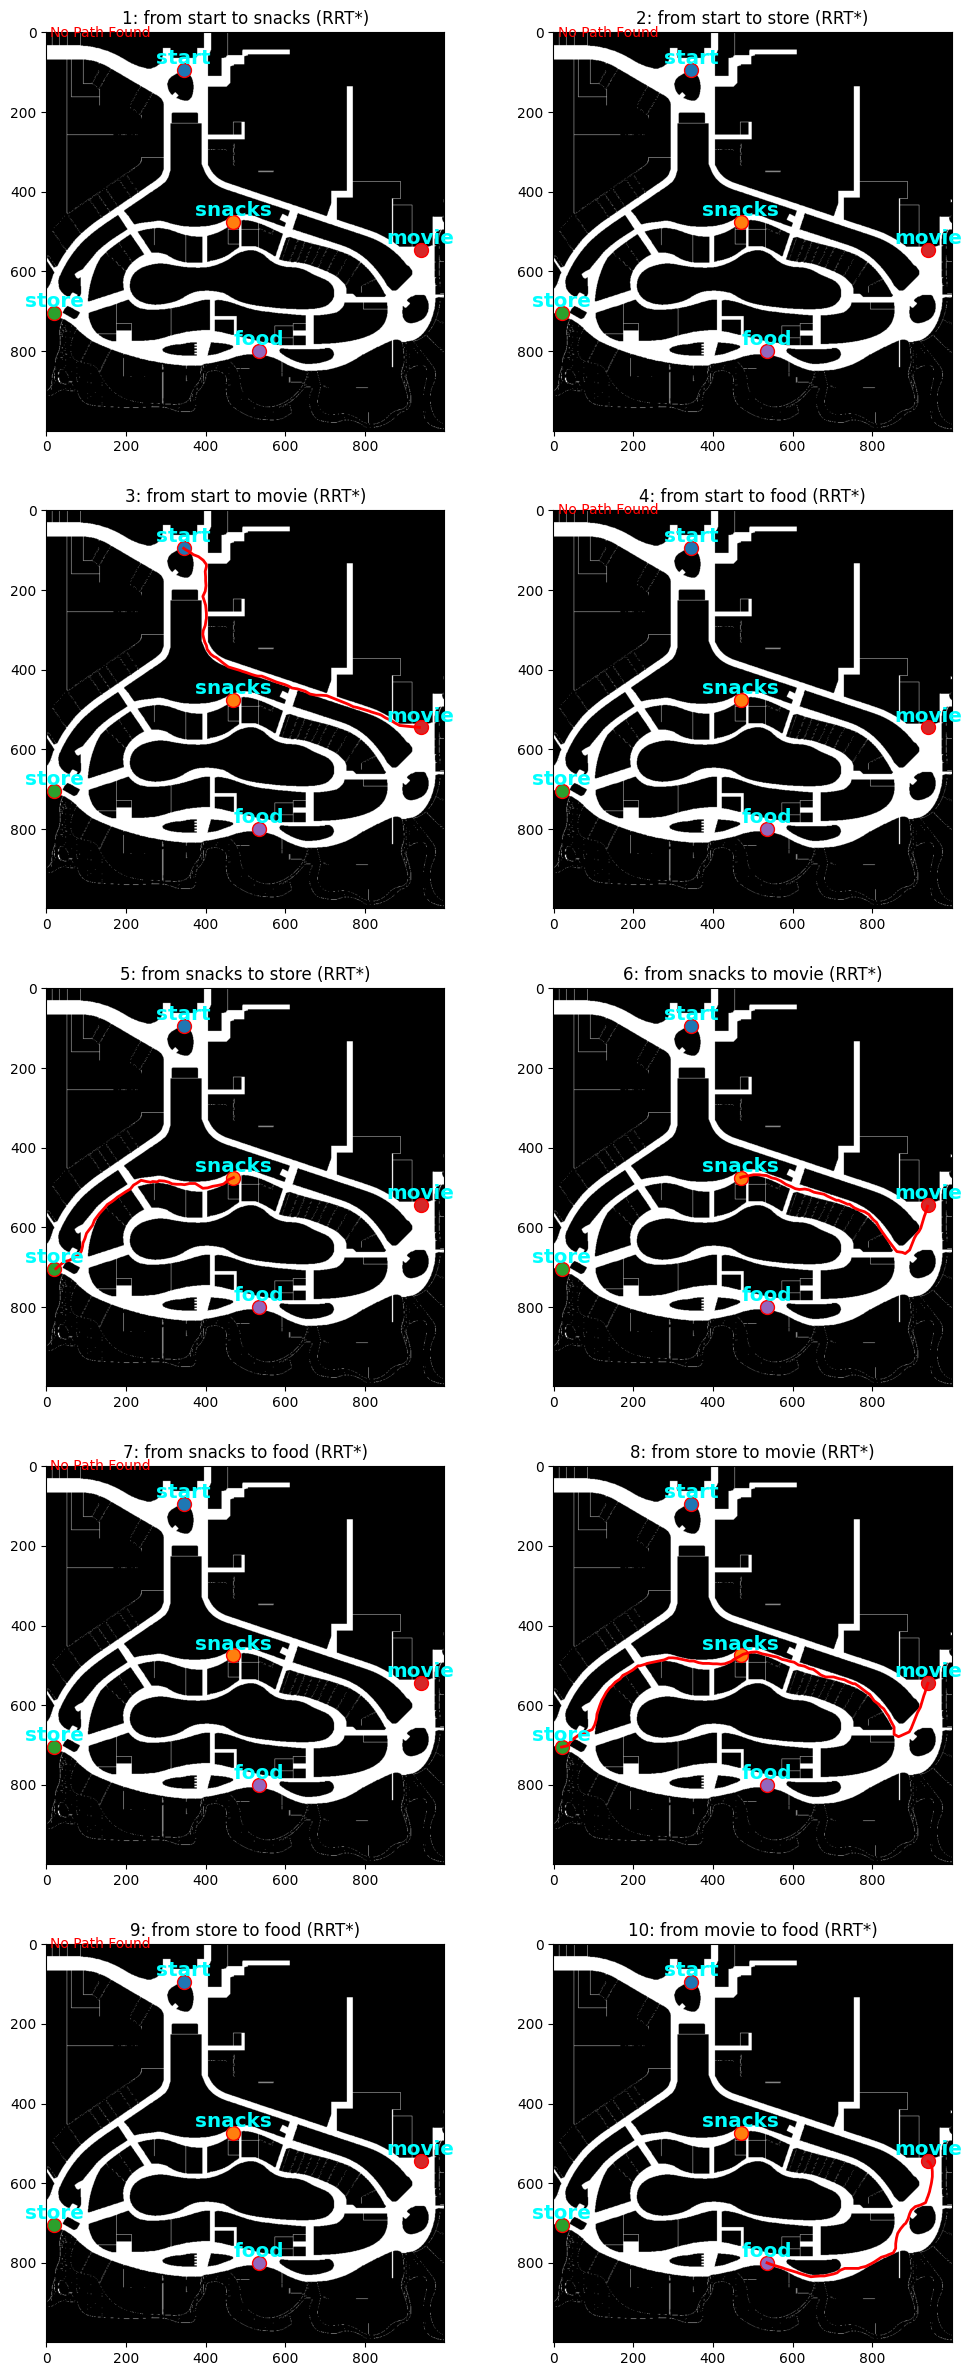

In [7]:
class Node:
    def __init__(self, pos, parent=None, cost=0.0):
        self.pos = pos
        self.parent = parent
        self.cost = cost  # 累计从 start 到该点的代价


def get_distance(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))


def steer(from_node, to_pos, max_step=5):
    direction = np.array(to_pos) - np.array(from_node.pos)
    length = np.linalg.norm(direction)
    if length == 0:
        return from_node.pos
    direction = direction / length
    step = min(max_step, length)
    new_pos = tuple(np.round(np.array(from_node.pos) + direction * step).astype(int))
    return new_pos


def is_collision_free(p, grid_map):
    x, y = p
    h, w = grid_map.shape
    return 0 <= x < h and 0 <= y < w and grid_map[x, y] == 255


def rrt_star(start, goal, grid_map, map_res, max_iter=5000, max_step=5, radius=15):
    h, w = grid_map.shape
    start_time = time.time()
    goal = tuple(goal)
    root = Node(tuple(start), cost=0.0)
    tree = [root]
    visited_cells = set()
    goal_tolerance = 5
    goal_node = None
    goal_bias = 0.5

    for _ in range(max_iter):
        # Sampling
        rand_pos = (
            goal
            if random.random() < goal_bias
            else (random.randint(0, h - 1), random.randint(0, w - 1))
        )

        # Nearest node
        nearest = min(tree, key=lambda node: get_distance(node.pos, rand_pos))
        new_pos = steer(nearest, rand_pos, max_step)

        if not is_collision_free(new_pos, grid_map):
            continue

        # Find nearby nodes for rewiring
        new_node = Node(new_pos)
        neighbor_nodes = [
            node
            for node in tree
            if get_distance(node.pos, new_pos) <= radius
            and is_collision_free(node.pos, grid_map)
        ]

        # Choose best parent
        min_cost = nearest.cost + get_distance(nearest.pos, new_pos)
        best_parent = nearest
        for node in neighbor_nodes:
            cost = node.cost + get_distance(node.pos, new_pos)
            if cost < min_cost:
                best_parent = node
                min_cost = cost
        new_node.parent = best_parent
        new_node.cost = min_cost
        tree.append(new_node)
        visited_cells.add(new_pos)

        # Rewire nearby nodes
        for node in neighbor_nodes:
            new_cost = new_node.cost + get_distance(new_node.pos, node.pos)
            if new_cost < node.cost:
                node.parent = new_node
                node.cost = new_cost

        # Check if close enough to goal
        if get_distance(new_node.pos, goal) <= goal_tolerance:
            if goal_node is None or new_node.cost < goal_node.cost:
                goal_node = new_node

    # Backtrack if success
    if goal_node is not None:
        path = []
        current = goal_node
        while current is not None:
            path.append(current.pos)
            current = current.parent
        path.reverse()
        total_dist = (
            sum(get_distance(path[i], path[i + 1]) for i in range(len(path) - 1))
            * map_res
        )
        runtime = time.time() - start_time
        return path, total_dist, visited_cells, runtime

    return None, float("inf"), visited_cells, time.time() - start_time


rrt_star_distance_table = {}
rrt_star_path_table = {}
rrt_star_runtime_table = {}
rrt_star_visited_count_table = {}

for from_key, to_key in itertools.combinations(keys, 2):
    start_pt = locations[from_key]
    goal_pt = locations[to_key]
    path, dist, visited_cells, runtime = rrt_star(
        start_pt, goal_pt, grid_map_dilated, MAP_RES
    )

    rrt_star_distance_table[(from_key, to_key)] = dist
    rrt_star_distance_table[(to_key, from_key)] = dist
    rrt_star_path_table[(from_key, to_key)] = path
    rrt_star_path_table[(to_key, from_key)] = path[::-1] if path else None
    rrt_star_visited_count_table[(from_key, to_key)] = len(visited_cells)
    rrt_star_visited_count_table[(to_key, from_key)] = len(visited_cells)
    rrt_star_runtime_table[(from_key, to_key)] = runtime
    rrt_star_runtime_table[(to_key, from_key)] = runtime

# Print distance table
print("\nDistance table (unit: meters) - RRT*")
print("From\\To\t" + "\t".join(keys))
for from_key in keys:
    row = [from_key]
    for to_key in keys:
        if from_key == to_key:
            row.append("0.0")
        else:
            row.append(f"{rrt_star_distance_table[(from_key, to_key)]:.2f}")
    print("\t".join(row))

# Visualize the optimal RRT* path for each cell
plt.figure(figsize=(12, 30))
plt_num = 1
for from_key, to_key in itertools.combinations(keys, 2):
    plt.subplot(5, 2, plt_num)
    plt.imshow(grid_map_img, cmap="gray")
    plot_locations(locations, color="cyan")
    plt.title(f"{plt_num}: from {from_key} to {to_key} (RRT*)")
    path = rrt_star_path_table[(from_key, to_key)]
    if path:
        x = [p[0] for p in path]
        y = [p[1] for p in path]
        plt.plot(x, y, c="red", linewidth=2)
    else:
        plt.text(10, 10, "No Path Found", color="red")
    plt_num += 1
plt.show()


## Task 2 The “Travelling Shopper” Problem

In [8]:
def brute_force_tsp(
    distance_table, visited_count_table, runtime_table, path_table, title
):
    min_total_dist = float("inf")
    best_route = []
    intermediate = ["snacks", "store", "movie", "food"]

    for perm in itertools.permutations(intermediate):
        route = ["start"] + list(perm) + ["start"]
        total_dist = 0
        for i in range(len(route) - 1):
            total_dist += distance_table[(route[i], route[i + 1])]
        if total_dist < min_total_dist:
            min_total_dist = total_dist
            best_route = route

    print(f"\nOptimal route for visiting: {' -> '.join(best_route)}")

    # Print performance metrics
    print("\nPerformance table")
    print("From -> To\t" + "Visited grids\t" + "Path length (m)\t" + "Run time (s)")
    for from_key, to_key in zip(best_route, best_route[1:]):
        from_to_key = str(from_key + "->" + to_key)
        row = [from_to_key]
        row.append(f"{visited_count_table[(from_key, to_key)]}\t")
        row.append(f"{distance_table[(from_key, to_key)]:.2f}\t")
        row.append(f"{runtime_table[(from_key, to_key)]:.4f}")
        print("\t".join(row))

    print(f"Total travel length: {min_total_dist:.2f} meters")

    # Visualize the optimal path
    plt.figure(figsize=(12, 12))
    plt.imshow(grid_map_img, cmap="gray")
    plot_locations(locations, color="cyan")
    for i in range(len(best_route) - 1):
        path = path_table[(best_route[i], best_route[i + 1])]
        x = [p[0] for p in path]
        y = [p[1] for p in path]
        plt.plot(x, y, c="red", linewidth=2)

    plt.title(title)
    plt.axis("off")
    plt.show()


def held_karp(distance_table, nodes, start="start"):
    @functools.lru_cache(maxsize=None)
    def dp(current, visited):
        if visited == all_visited:
            return distance_table[(current, start)], [start]

        min_dist = float("inf")
        best_subpath = []
        for nxt in nodes:
            if not (visited & (1 << node_index[nxt])):
                dist, subpath = dp(nxt, visited | (1 << node_index[nxt]))
                dist += distance_table[(current, nxt)]
                if dist < min_dist:
                    min_dist = dist
                    best_subpath = [nxt] + subpath
        return min_dist, best_subpath

    # Encode each point as a binary bit
    node_index = {name: i for i, name in enumerate(nodes)}
    all_visited = (1 << len(nodes)) - 1

    min_dist, path = dp(start, 0)
    full_path = [start] + path
    return full_path, min_dist


def held_karp_tsp(
    distance_table, visited_count_table, runtime_table, path_table, title
):
    intermediate = ["snacks", "store", "movie", "food"]
    best_route, min_total_dist = held_karp(distance_table, intermediate)

    print(f"\nOptimal route for visiting: {' -> '.join(best_route)}")

    # Print performance metrics
    print("\nPerformance table")
    print("From -> To\t" + "Visited grids\t" + "Path length (m)\t" + "Run time (s)")
    for from_key, to_key in zip(best_route, best_route[1:]):
        from_to_key = str(from_key + "->" + to_key)
        row = [from_to_key]
        row.append(f"{visited_count_table[(from_key, to_key)]}\t")
        row.append(f"{distance_table[(from_key, to_key)]:.2f}\t")
        row.append(f"{runtime_table[(from_key, to_key)]:.4f}")
        print("\t".join(row))

    print(f"Total travel length: {min_total_dist:.2f} meters")

    # Visualize the optimal path
    plt.figure(figsize=(12, 12))
    plt.imshow(grid_map_img, cmap="gray")
    plot_locations(locations, color="cyan")
    for i in range(len(best_route) - 1):
        path = path_table[(best_route[i], best_route[i + 1])]
        x = [p[0] for p in path]
        y = [p[1] for p in path]
        plt.plot(x, y, c="red", linewidth=2)

    plt.title(title)
    plt.axis("off")
    plt.show()


### Task 2.1 Heuristic Function - Euclidean Distance


Optimal route for visiting: start -> snacks -> movie -> food -> store -> start

Performance table
From -> To	Visited grids	Path length (m)	Run time (s)
start->snacks	34394		143.28		0.4524
snacks->movie	11010		108.11		0.1153
movie->food	25765		113.71		0.3951
food->store	16645		111.12		0.1693
store->start	27953		155.26		0.4093
Total travel length: 631.48 meters


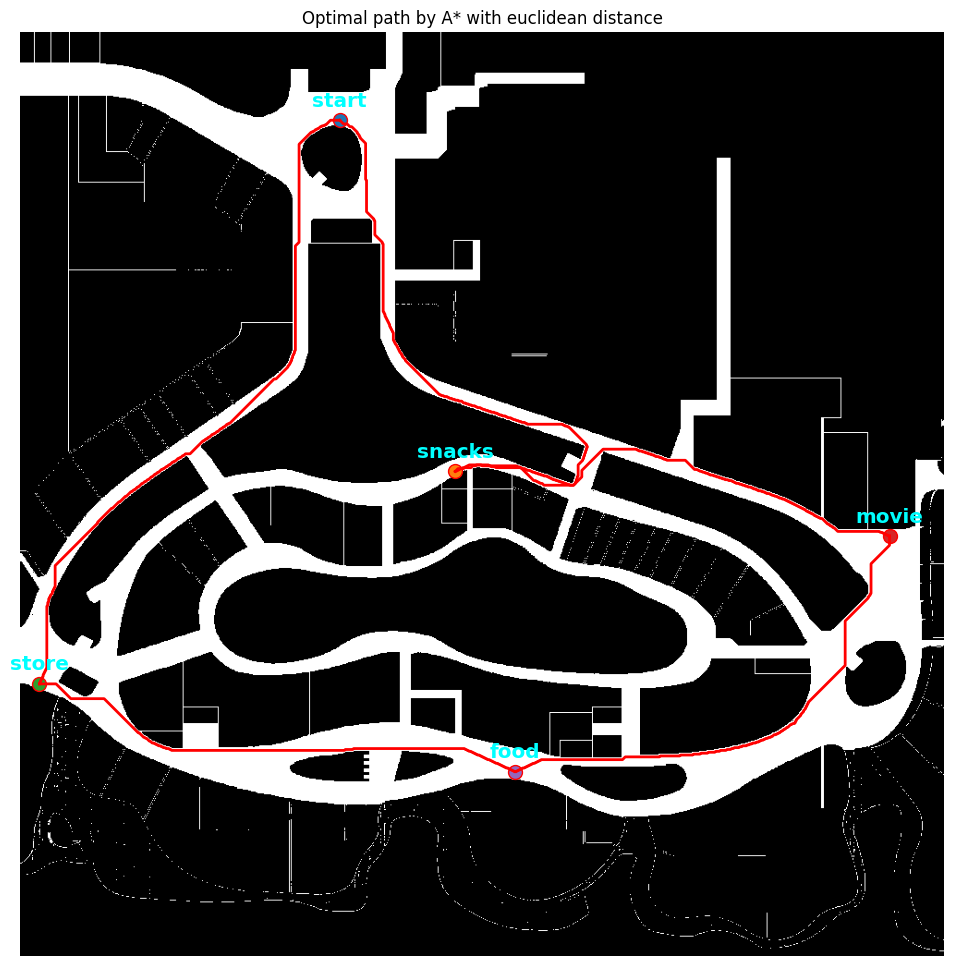


Optimal route for visiting: start -> snacks -> movie -> food -> store -> start

Performance table
From -> To	Visited grids	Path length (m)	Run time (s)
start->snacks	34394		143.28		0.4524
snacks->movie	11010		108.11		0.1153
movie->food	25765		113.71		0.3951
food->store	16645		111.12		0.1693
store->start	27953		155.26		0.4093
Total travel length: 631.48 meters


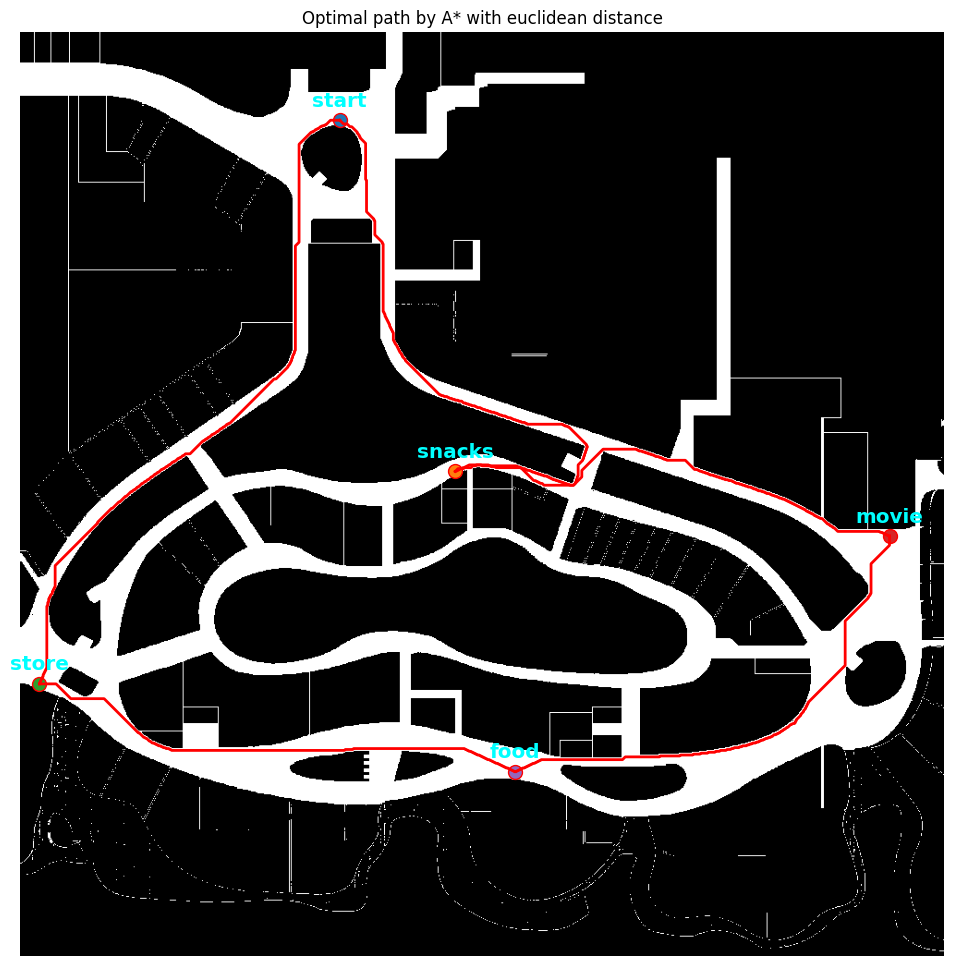

In [9]:
brute_force_tsp(
    astar_ed_distance_table,
    astar_ed_visited_count_table,
    astar_ed_runtime_table,
    astar_ed_path_table,
    "Optimal path by A* with euclidean distance",
)
held_karp_tsp(
    astar_ed_distance_table,
    astar_ed_visited_count_table,
    astar_ed_runtime_table,
    astar_ed_path_table,
    "Optimal path by A* with euclidean distance",
)

### Task 2.2 Heuristic Function - Manhattan Distance


Optimal route for visiting: start -> snacks -> movie -> food -> store -> start

Performance table
From -> To	Visited grids	Path length (m)	Run time (s)
start->snacks	30026		143.28		0.8563
snacks->movie	8414		108.11		0.4543
movie->food	1361		114.30		0.0182
food->store	6290		111.12		0.6461
store->start	2260		155.26		0.0343
Total travel length: 632.07 meters


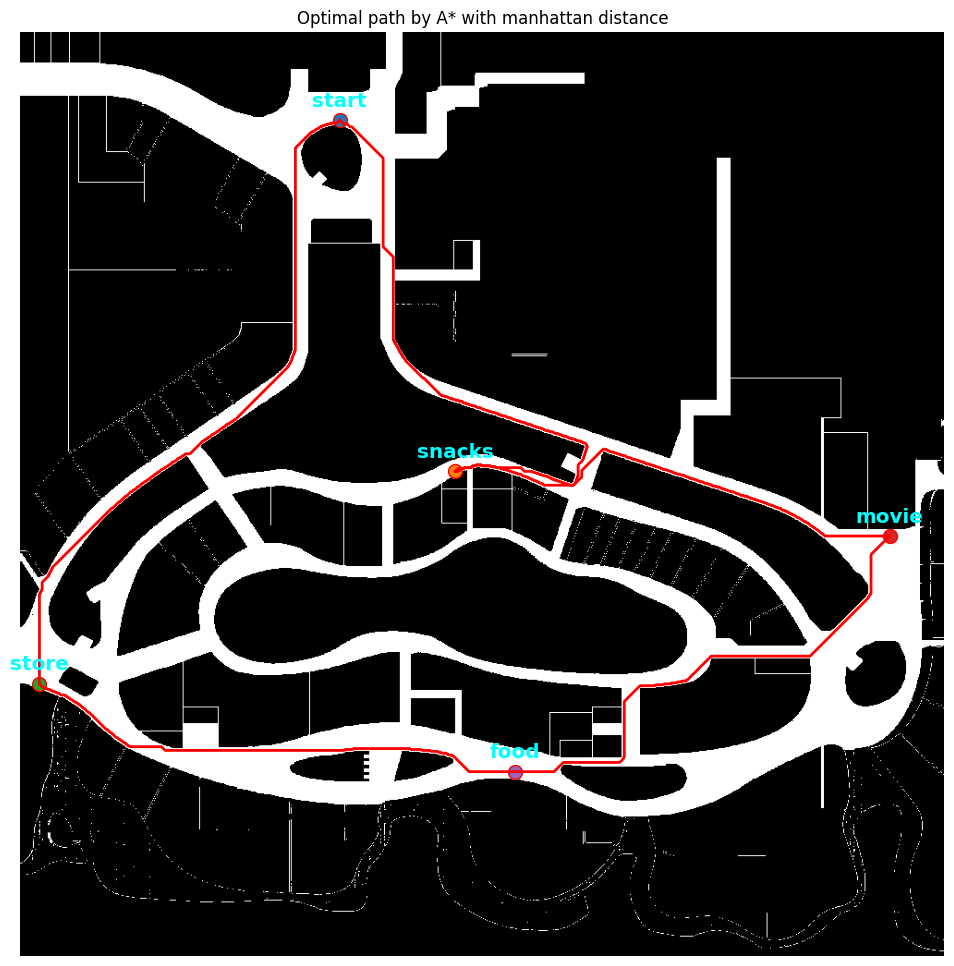


Optimal route for visiting: start -> snacks -> movie -> food -> store -> start

Performance table
From -> To	Visited grids	Path length (m)	Run time (s)
start->snacks	30026		143.28		0.8563
snacks->movie	8414		108.11		0.4543
movie->food	1361		114.30		0.0182
food->store	6290		111.12		0.6461
store->start	2260		155.26		0.0343
Total travel length: 632.07 meters


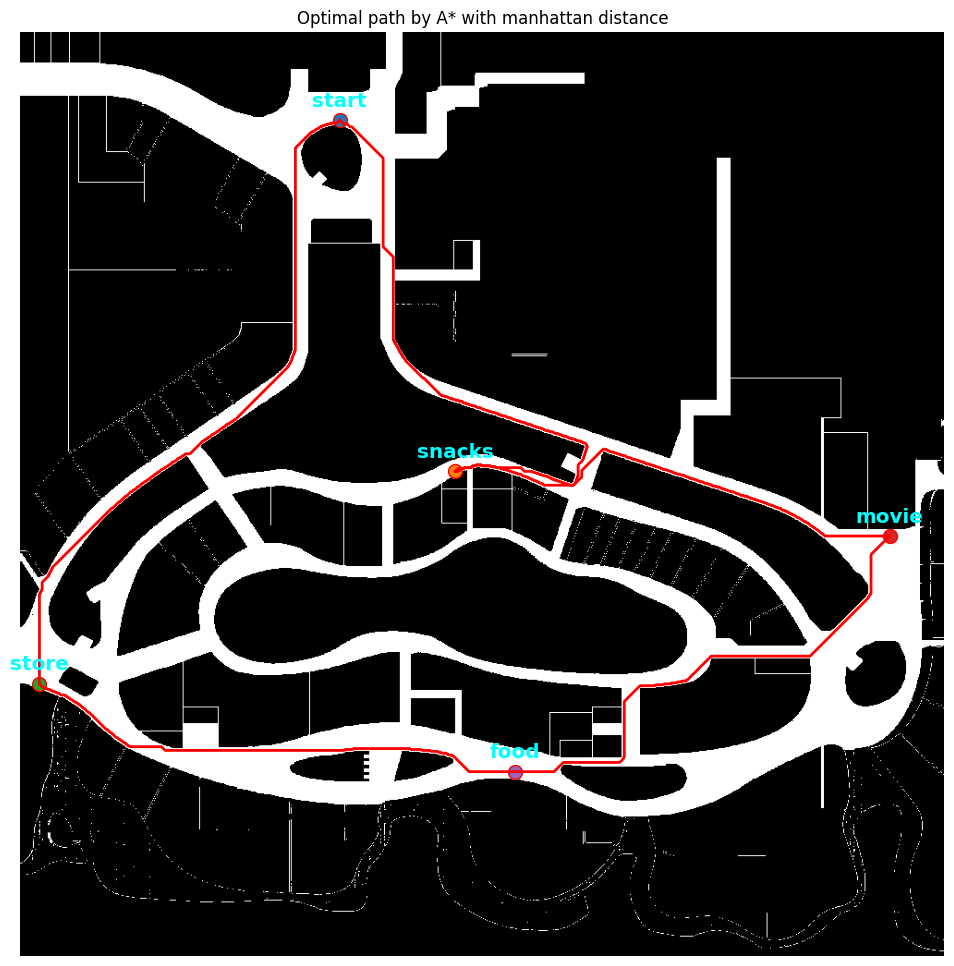

In [10]:
brute_force_tsp(
    astar_md_distance_table,
    astar_md_visited_count_table,
    astar_md_runtime_table,
    astar_md_path_table,
    "Optimal path by A* with manhattan distance",
)
held_karp_tsp(
    astar_md_distance_table,
    astar_md_visited_count_table,
    astar_md_runtime_table,
    astar_md_path_table,
    "Optimal path by A* with manhattan distance",
)

### Task 2.3 Greedy Best First Search Algorithm （GBFS）


Optimal route for visiting: start -> movie -> food -> store -> snacks -> start

Performance table
From -> To	Visited grids	Path length (m)	Run time (s)
start->movie	2952		182.48		0.0183
movie->food	4150		208.22		0.0285
food->store	1459		119.03		0.0065
store->snacks	1461		124.00		0.0066
snacks->start	4746		146.29		0.0407
Total travel length: 780.01 meters


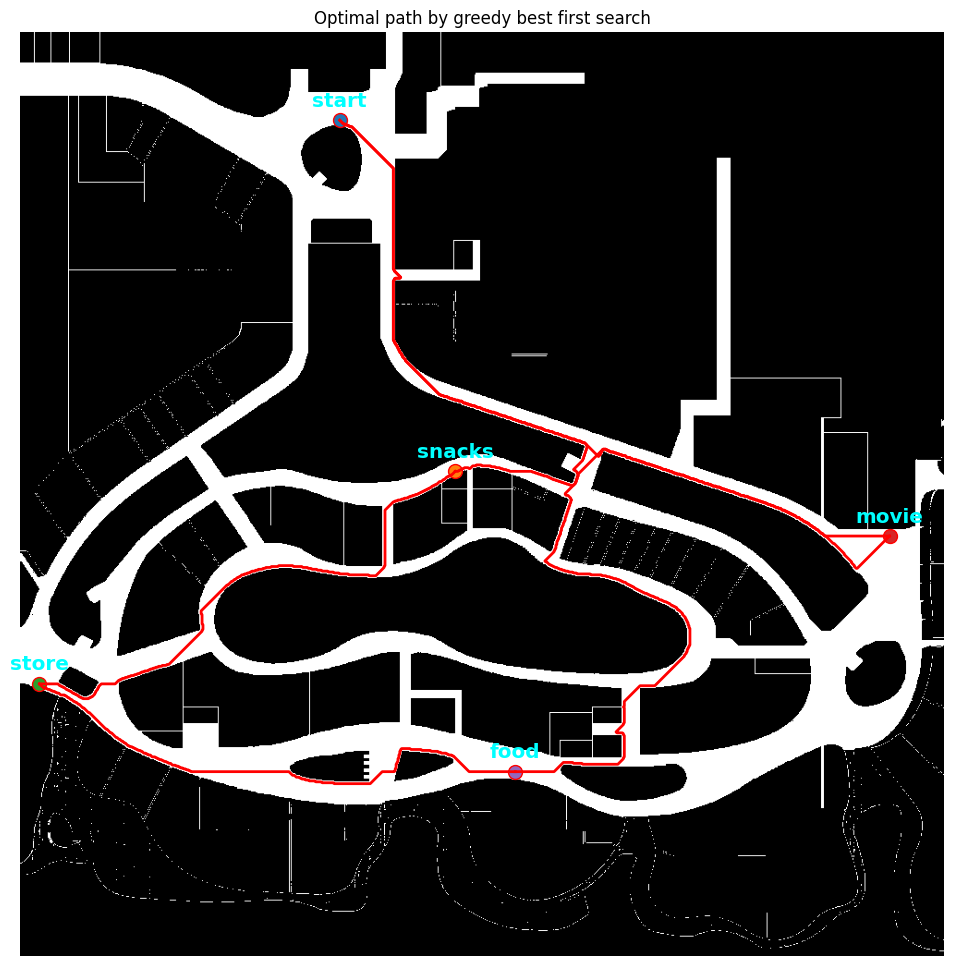


Optimal route for visiting: start -> snacks -> store -> food -> movie -> start

Performance table
From -> To	Visited grids	Path length (m)	Run time (s)
start->snacks	4746		146.29		0.0407
snacks->store	1461		124.00		0.0066
store->food	1459		119.03		0.0065
food->movie	4150		208.22		0.0285
movie->start	2952		182.48		0.0183
Total travel length: 780.01 meters


In [11]:
brute_force_tsp(
    gbfs_distance_table,
    gbfs_visited_count_table,
    gbfs_runtime_table,
    gbfs_path_table,
    "Optimal path by greedy best first search",
)
held_karp_tsp(
    gbfs_distance_table,
    gbfs_visited_count_table,
    gbfs_runtime_table,
    gbfs_path_table,
    "Optimal path by greedy best first search",
)

## Task 3
git@github.com:YukiKuma111/NUS_ME5413_Homework3_Planning.git